In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from optimize_parameters import optimize_alpha
from distance_calculations_source import distance
from new_clustering_algorithm import cluster_by_connecting_centroids

def np_relu(x):
    
    return np.maximum(0,x)


def initialize_Z(W, dat):
    
    W_t = np.transpose(W)
    lmda = 0.1
    inverse_term = np.linalg.inv(np.eye(W.shape[0]) + (lmda ** -1) * np.matmul(W,W_t))
    woodbury = (lmda ** -1) * np.eye(W.shape[1]) - np.matmul((lmda ** -2) * W_t , np.matmul(inverse_term, W))
    Z = np_relu(np.matmul(woodbury, np.matmul(W_t,dat)))
    
    return Z


def maximize_function(w, z, x):
    
    mean = np.matmul(w, z)
    mean = 1e-10 + np_relu(mean)
    negative_log_likelihood = np.sum(- mean + np.multiply(x, np.log(mean)))

    return negative_log_likelihood


def calc_aic(w, z, x):

    mean = np.matmul(w, z)
    mean = 1e-10 + np_relu(mean)
    log_likelihood = np.sum(- mean + np.multiply(x, np.log(mean)))
    # print('differences', np.count_nonzero(np_relu(w) > 1e-05) - np.count_nonzero(np_relu(z) > 1e-05))
    AIC = log_likelihood - np.count_nonzero(np_relu(w) > 1e-05) - np.count_nonzero(np_relu(z) > 1e-05)
    
    return AIC


""" Multiplicative Updates """

def multiplicative_updates(W, Z, X, n, method):
    
    lw = 0.0
    lz = 1e-01
    beta = 0.5
    convergence_criteria = 0.0001
    epsilon_reg = 1e-05
    loss_values = []
    
    global AIC
    
    if method == 0:
        
        for i in range(n):

            mean = np.matmul(W, Z)
            mean = 1e-10 + np_relu(mean)
            X_by_mean = X / mean

            W = np.multiply(W, np_relu(np.matmul(X_by_mean, np.transpose(Z))))
            W = W / np.sum(W, axis = 0)
            Z = np.multiply(Z, np_relu(np.matmul(np.transpose(W), X_by_mean)))

            loss_values.append(maximize_function(W, Z, X))
            
            if len(loss_values) >= 10 :
                
                if ((loss_values[i] - loss_values[i-10]) / loss_values[i]) < convergence_criteria:
                    AIC = calc_aic(W, Z, X)
                    # print("Function is converged")
                    break
        return  W, Z, loss_values, AIC
    
    
    if method == 1:
        
        for i in range(n):

            mean = np.matmul(W, Z)
            mean = 1e-10 + np_relu(mean)
            X_by_mean = X / mean

            Z_reg =  (lz * beta) / np.power(np.abs(Z+epsilon_reg), 1-beta)
            Z = np.multiply(Z, np_relu(np.matmul(np.transpose(W), X_by_mean) - Z_reg))
            
            loss_values.append(maximize_function(W, Z, X))

            if len(loss_values) >= 10 :
                if ((loss_values[i] - loss_values[i-10]) / loss_values[i]) < convergence_criteria:
                    AIC = calc_aic(W, Z, X)
                    # print("Function is converged")
                    break
                
        return  Z, loss_values, AIC
    
    
    if method == 2:
        
        for i in range(n):

            mean = np.matmul(W, Z)
            mean = 1e-10 + np_relu(mean)
            X_by_mean = X / mean

            W_reg =  (lw * beta) / np.power(np.abs(W+epsilon_reg), 1-beta)
            Z_reg =  (lz * beta) / np.power(np.abs(Z+epsilon_reg), 1-beta)

            W = np.multiply(W, np_relu(np.matmul(X_by_mean, np.transpose(Z)) - W_reg))
            W = W / np.sum(W, axis = 0) 
            Z = np.multiply(Z, np_relu(np.matmul(np.transpose(W), X_by_mean) - Z_reg))

            loss_values.append(maximize_function(W, Z, X))

            # if len(loss_values) >= 10 :
            #     if ((loss_values[i] - loss_values[i-10]) / loss_values[i]) < convergence_criteria:
            #         AIC = calc_aic(W, Z, X)
            #         # print("Function is converged")
            #         break
                
        return  W, Z, loss_values, AIC

    
""" End multiplicative updates """
                               
                                
if __name__ == "__main__":
    
    s = time.time()
    print("clustering initiated")
    tmp_dir = "/big/work/metadevol/benchmark_dataset1/"
    # tmp_dir = "/big/work/metadevol/scripts/bamtools_api/build/"
    dat = pd.read_pickle(tmp_dir + 'X_pickle')
    contig_names = dat.columns
    d0 = 1
    min_shared_contigs = 5
    s_start = time.time()
    clusters, numclust_incomponents, an, alpha, N = cluster_by_connecting_centroids(dat, d0, min_shared_contigs)
    print("distance_calculation:", time.time() - s_start)
    print("overall time taken for new clustering is: ", time.time()-s)
    
    label = pd.read_csv(tmp_dir + 'contigs_ids_distindex', sep =' ', header = None)
    # label = pd.read_csv(tmp_dir + 'contigs_refid_genomeid_withcrossmappeddata', sep =' ', header = None)
    lc = np.array(label[3])
    
    dat = dat.to_numpy()
   
    num_iterations = 100
    
    W_full = []
    Z_zbc_lcov = []
    epsilon = 1e-10


    for k in np.arange(len(numclust_incomponents)):

        if numclust_incomponents[k] > 1 :
            dat_s = dat[:, clusters[k]]
            lc_s = lc[clusters[k]]
            Rc_s = dat_s.sum(axis = 0)
            AIC_score = []
            
            optimized = {}
            
            LL_values = {}
            
            for _ in range(3):
                
                trial_bval = _
                k_contigs = []

                if trial_bval == 0:
                    k_contigs = dat_s.sum(axis=1) + epsilon
                    k_contigs = k_contigs.reshape(N,1)

                else:
                    if trial_bval + 1 <= numclust_incomponents[k]: 

                        ind = []

                        for i in range(trial_bval+1):

                            if i == 0:

                                c0_ind = np.argmax(dat_s.sum(axis=0))
                                print(dat_s.sum(axis=0), c0_ind)
                                c0 = dat_s[:, [c0_ind]]
                                dist = distance(c0, dat_s, Rc_s[c0_ind], Rc_s, N, an, alpha)
                                c_ind = np.argmax(dist)
                                c = dat_s[:, [c_ind]]
                                k_contigs = c
                                ind.append(c_ind)

                            else:

                                dist_sum = []

                                for f in range(np.shape(k_contigs)[1]):
                                    dist_sum.append(distance(k_contigs[:,[f]],dat_s, Rc_s[ind[f]], Rc_s, N, an, alpha))
                                # print('distance', np.shape(np.array(dist_sum)),  np.max(np.array(dist_sum)), np.array(dist_sum).sum(axis=0))
                                f_ind = np.argmax(np.array(dist_sum).sum(axis=0))
                                ind.append(f_ind)
                                k_contigs = np.hstack((k_contigs, dat_s[:, [f_ind]])) 
                    print(k, ind, c0_ind)
                W = np.array(k_contigs) 
                
                W_norm = W / W.sum(axis = 0)
            
                if not np.shape(W)[0] == 0:
                    
                    Z = initialize_Z(W_norm, dat_s)

                    W_opt, Z_opt, LL, AIC = multiplicative_updates(W_norm, Z, dat_s, num_iterations, 0)
                    optimized["W"+str(trial_bval)] = W_opt
                    optimized["Z"+str(trial_bval)] = Z_opt
                    AIC_score.append(AIC)
                    LL_values[str(trial_bval)] = LL

            # obtain best k using maximum AIC value    
            bval = np.argmax(AIC_score)
            print(k, bval, AIC_score)
            W_full.append(optimized["W"+str(bval)])
            # z_bc = optimized["Z"+str(bval)]
            # weights = (optimized["Z"+str(bval)] ** 5) / (Rc_s ** 4)
            # weights_summedoverC = np.sum(weights, axis=1, keepdims = True)
            # small_cov_b = np.sum((weights * (z_bc / lc_s) / weights_summedoverC), axis=1, keepdims=True)
            # z_bc_corrected = z_bc/(lc_s * small_cov_b)
            # Z_zbc_lcov.append(z_bc_corrected)
            # zbcsum_value = np.sum(z_bc_corrected, axis=0)
            # print(k, np.min(zbcsum_value), np.max(zbcsum_value))
            # if k == 21:
            #     print(z_bc_corrected[:,np.nonzero(clusters[k] == 41399)])

        else:

            dat_s = dat[:, clusters[k]].sum(axis=1) + epsilon
            dat_s = dat_s.reshape(N,1) 
            dat_s = dat_s / dat_s.sum() # not resulting in 1.0 (eg., 0.9999999999999998, 1.0000000000000002)
            W_full.append(dat_s)
            # z_bc = initialize_Z(dat_s, dat_s)
            # weights = (z_bc ** 5) / (Rc_s ** 4)
            # weights_summedoverC = np.sum(weights, axis=1, keepdims = True)
            # small_cov_b = np.sum((weights * (z_bc / lc_s) / weights_summedoverC), axis=1, keepdims=True)
            # Z_zbc_lcov.append(z_bc/(lc_s * small_cov_b))

    W_full = np.concatenate(W_full, axis = 1)
    # Z_zbc_lcov = np.concatenate(Z_zbc_lcov, axis = 0)
    print(np.shape(W_full))

    Z = initialize_Z(W_full, dat)
    
    # LL.append(maximize_function(W_full, Z, dat))

    Z_full, LL, AIC_score = multiplicative_updates(W_full, Z, dat, num_iterations, 1)
    # LL.append(LL_values)
    
    # plt.plot(LL)
    # W_fullopt, Z_fullopt, LL, AIC_final = multiplicative_updates(W_full, Z_full, dat, num_iterations, 2)
    
    
    
    # """ Assignment """
    # Z_assign = Z_full
    # Rc_c  = np.sum(Z_assign, axis=0)
    # pb_c  = Z_assign / Rc_c
    # cov_b = np.sum(Z_assign, axis=1) / np.sum((np.array(lc) * Z_assign) / Rc_c, axis=1)
    # pb_min = 0.8 * (cov_b.reshape(len(cov_b),1) * np.sum(np.square(pb_c), axis=0) \
    #                 / np.sum(cov_b.reshape(len(cov_b),1) * pb_c, axis=0))
    # pb_min[pb_min > 0.5] = 0.5
    # contig_assign0 = np.argmax(pb_c/pb_min, axis=0)
    
    # print(len(set(contig_assign0)), "number of bins")
    # print(len(set(np.argmax(Z_assign, axis=0))), "just max")


    # """ New assignment - more than one bins for contigs is possible"""
    Z_assign = Z_full
    Rc_c  = np.sum(Z_assign, axis=0)
    pb_c  = np.power(Z_assign/Rc_c,4)
    Z_l = Z_assign / np.array(lc)

    cov_b = (np.multiply(pb_c,Z_l).sum(axis=1)) / pb_c.sum(axis=1)

    pi_bc1 = Z_assign / np.row_stack(cov_b)
    pi_bc2 = pi_bc1.sum(axis=0)

    pi_bc = pi_bc1 / pi_bc2

    np.argwhere(pi_bc>0.2)
    # np.savetxt(tmp_dir + "indices_pibc_bins",np.argwhere(pi_bc>0.2), fmt="%d")

clustering initiated
alpha optimized is: 8.440742299720526 and took 1.8392369747161865 seconds

distance 16617 [ 317.58276 3726.2012   176.81976 ... 3427.8384   270.10718  803.51074]
distance 38278 [ 699.8026  7431.09     326.69336 ... 6096.376    581.94763 1523.3312 ]
distance 38780 [ 579.5442  5852.741    242.60696 ... 4714.235    454.28674 1046.0857 ]
distance 15570 [3.6858984e+02 4.0388760e+03 1.9171124e+02 ... 1.5061816e+03 2.6598486e+02
 6.3196830e-02]
distance 14256 [ 312.786   3404.8428   225.97943 ... 2961.395    230.05774  993.09705]
distance 35856 [ 402.9358  4165.2524    66.50714 ... 3530.7686   357.2417  1249.8176 ]
distance 34004 [ 367.30566 3075.8086   162.10043 ... 2685.3445   280.9181   794.86206]
distance 841 [2.2618010e-09 1.1738038e-19 8.3237061e+01 ... 2.3120581e+03 2.0004229e-09
 8.7098102e+02]
distance 5053 [ 401.45752 2703.8555   144.03824 ... 2394.5261   350.2447   867.53467]
distance 37063 [ 399.4889 3177.3347  166.2413 ... 1985.7732  329.7246 1055.4635]
dista

/home/yazhini/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


2 [78, 1136] 1138
2 0 [2416326.159690858, 2414292.386825543]
[145.  146.5 128.5 ... 127.  112.5 145.5] 1583
4 [859, 2126] 1583
4 [859, 2126] 1583
4 0 [3238578.4103596546, 3232883.095063657]
[122.5  219.   141.   ... 190.25  74.    98.  ] 899
6 [567, 939] 899
6 [567, 939] 899
6 0 [1663338.2785912915, 1662726.3378422002]
[ 242.5  2955.25 3153.   ...  117.5    90.5   203.  ] 164
7 [259, 3392] 164
[ 242.5  2955.25 3153.   ...  117.5    90.5   203.  ] 164
7 [259, 3392, 164] 164
7 1 [6321806.277651154, 6360817.001691559, 6352230.854011486]
[126.5  76.5  98.  ... 135.   86.  232. ] 2832
16 [487, 556] 2832
16 [487, 556] 2832
16 0 [602947.5195073833, 596051.5745669708]
[ 23.         18.5        16.         20.         28.5        19.5
  19.         24.5        22.5        35.5        28.         17.5
  20.         28.         13.5        24.5        98.         31.
  20.5        21.5       157.5        18.         20.        159.
  15.5        17.         24.5        13.         40.5        21.

In [18]:
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from optimize_parameters import optimize_alpha
from distance_calculations_source import distance
from new_clustering_algorithm import cluster_by_connecting_centroids

def np_relu(x):
    
    return np.maximum(0,x)


def initialize_Z(W, dat):
    
    W_t = np.transpose(W)
    lmda = 0.1
    inverse_term = np.linalg.inv(np.eye(W.shape[0]) + (lmda ** -1) * np.matmul(W,W_t))
    woodbury = (lmda ** -1) * np.eye(W.shape[1]) - np.matmul((lmda ** -2) * W_t , np.matmul(inverse_term, W))
    Z = np_relu(np.matmul(woodbury, np.matmul(W_t,dat)))
    
    return Z


def maximize_function(w, z, x):
    
    mean = np.matmul(w, z)
    mean = 1e-10 + np_relu(mean)
    negative_log_likelihood = np.sum(- mean + np.multiply(x, np.log(mean)))

    return negative_log_likelihood


def calc_aic(w, z, x):

    mean = np.matmul(w, z)
    mean = 1e-10 + np_relu(mean)
    log_likelihood = np.sum(- mean + np.multiply(x, np.log(mean)))
    # print('differences', np.count_nonzero(np_relu(w) > 1e-05) - np.count_nonzero(np_relu(z) > 1e-05))
    AIC = log_likelihood - np.count_nonzero(np_relu(w) > 1e-05) - np.count_nonzero(np_relu(z) > 1e-05)
    
    return AIC


""" Multiplicative Updates """

def multiplicative_updates(W, Z, X, n, method):
    
    lw = 0.0
    lz = 1e-01
    beta = 0.5
    convergence_criteria = 0.0001
    epsilon_reg = 1e-05
    loss_values = []
    
    global AIC
    
    if method == 0:
        
        for i in range(n):

            mean = np.matmul(W, Z)
            mean = 1e-10 + np_relu(mean)
            X_by_mean = X / mean

            W = np.multiply(W, np_relu(np.matmul(X_by_mean, np.transpose(Z))))
            W = W / np.sum(W, axis = 0)
            Z = np.multiply(Z, np_relu(np.matmul(np.transpose(W), X_by_mean)))

            loss_values.append(maximize_function(W, Z, X))
            
            if len(loss_values) >= 10 :
                
                if ((loss_values[i] - loss_values[i-10]) / loss_values[i]) < convergence_criteria:
                    AIC = calc_aic(W, Z, X)
                    # print("Function is converged")
                    break
        return  W, Z, loss_values, AIC
    
    
    if method == 1:
        
        for i in range(n):

            mean = np.matmul(W, Z)
            mean = 1e-10 + np_relu(mean)
            X_by_mean = X / mean

            Z_reg =  (lz * beta) / np.power(np.abs(Z+epsilon_reg), 1-beta)
            Z = np.multiply(Z, np_relu(np.matmul(np.transpose(W), X_by_mean) - Z_reg))
            
            loss_values.append(maximize_function(W, Z, X))

            if len(loss_values) >= 10 :
                if ((loss_values[i] - loss_values[i-10]) / loss_values[i]) < convergence_criteria:
                    AIC = calc_aic(W, Z, X)
                    # print("Function is converged")
                    break
                
        return  Z, loss_values, AIC
    
    
    if method == 2:
        
        for i in range(n):

            mean = np.matmul(W, Z)
            mean = 1e-10 + np_relu(mean)
            X_by_mean = X / mean

            W_reg =  (lw * beta) / np.power(np.abs(W+epsilon_reg), 1-beta)
            Z_reg =  (lz * beta) / np.power(np.abs(Z+epsilon_reg), 1-beta)

            W = np.multiply(W, np_relu(np.matmul(X_by_mean, np.transpose(Z)) - W_reg))
            W = W / np.sum(W, axis = 0) 
            Z = np.multiply(Z, np_relu(np.matmul(np.transpose(W), X_by_mean) - Z_reg))

            loss_values.append(maximize_function(W, Z, X))

            # if len(loss_values) >= 10 :
            #     if ((loss_values[i] - loss_values[i-10]) / loss_values[i]) < convergence_criteria:
            #         AIC = calc_aic(W, Z, X)
            #         # print("Function is converged")
            #         break
                
        return  W, Z, loss_values, AIC

    
""" End multiplicative updates """
                               
                                
if __name__ == "__main__":
    
    s = time.time()
    print("clustering initiated")
    tmp_dir = "/big/work/metadevol/benchmark_dataset1/"
    # tmp_dir = "/big/work/metadevol/scripts/bamtools_api/build/"
    dat = pd.read_pickle(tmp_dir + 'X_pickle')
    contig_names = dat.columns
    d0 = 1
    min_shared_contigs = 5
    s_start = time.time()
    clusters, numclust_incomponents, an, alpha, N = cluster_by_connecting_centroids(dat, d0, min_shared_contigs)
    print("distance_calculation:", time.time() - s_start)
    print("overall time taken for new clustering is: ", time.time()-s)
    
    label = pd.read_csv(tmp_dir + 'contigs_ids_distindex', sep =' ', header = None)
    # label = pd.read_csv(tmp_dir + 'contigs_refid_genomeid_withcrossmappeddata', sep =' ', header = None)
    lc = np.array(label[3])
    
    dat = dat.to_numpy()

    dat = read_counts
   
    num_iterations = 100
    
    W_full = []
    Z_zbc_lcov = []
    epsilon = 1e-10


    for k in np.arange(len(numclust_incomponents)):

        if numclust_incomponents[k] > 1 :
            dat_s = dat[:, clusters[k]]
            lc_s = lc[clusters[k]]
            Rc_s = dat_s.sum(axis = 0)
            AIC_score = []
            
            optimized = {}
            
            LL_values = {}
            
            for _ in range(3):
                
                trial_bval = _
                k_contigs = []

                if trial_bval == 0:
                    k_contigs = dat_s.sum(axis=1) + epsilon
                    k_contigs = k_contigs.reshape(N,1)

                else:
                    if trial_bval + 1 <= numclust_incomponents[k]: 

                        ind = []

                        for i in range(trial_bval+1):

                            if i == 0:

                                c0_ind = np.argmax(dat_s.sum(axis=0))
                                print(dat_s.sum(axis=0), c0_ind)
                                c0 = dat_s[:, [c0_ind]]
                                dist = distance(c0, dat_s, Rc_s[c0_ind], Rc_s, N, an, alpha)
                                c_ind = np.argmax(dist)
                                c = dat_s[:, [c_ind]]
                                k_contigs = c
                                ind.append(c_ind)

                            else:

                                dist_sum = []

                                for f in range(np.shape(k_contigs)[1]):
                                    dist_sum.append(distance(k_contigs[:,[f]],dat_s, Rc_s[ind[f]], Rc_s, N, an, alpha))
                                # print('distance', np.shape(np.array(dist_sum)),  np.max(np.array(dist_sum)), np.array(dist_sum).sum(axis=0))
                                f_ind = np.argmax(np.array(dist_sum).sum(axis=0))
                                ind.append(f_ind)
                                k_contigs = np.hstack((k_contigs, dat_s[:, [f_ind]])) 
                    print(k, ind, c0_ind)
                W = np.array(k_contigs) 
                
                W_norm = W / W.sum(axis = 0)
            
                if not np.shape(W)[0] == 0:
                    
                    Z = initialize_Z(W_norm, dat_s)

                    W_opt, Z_opt, LL, AIC = multiplicative_updates(W_norm, Z, dat_s, num_iterations, 0)
                    optimized["W"+str(trial_bval)] = W_opt
                    optimized["Z"+str(trial_bval)] = Z_opt
                    AIC_score.append(AIC)
                    LL_values[str(trial_bval)] = LL

            # obtain best k using maximum AIC value    
            bval = np.argmax(AIC_score)
            print(k, bval, AIC_score)
            W_full.append(optimized["W"+str(bval)])
            # z_bc = optimized["Z"+str(bval)]
            # weights = (optimized["Z"+str(bval)] ** 5) / (Rc_s ** 4)
            # weights_summedoverC = np.sum(weights, axis=1, keepdims = True)
            # small_cov_b = np.sum((weights * (z_bc / lc_s) / weights_summedoverC), axis=1, keepdims=True)
            # z_bc_corrected = z_bc/(lc_s * small_cov_b)
            # Z_zbc_lcov.append(z_bc_corrected)
            # zbcsum_value = np.sum(z_bc_corrected, axis=0)
            # print(k, np.min(zbcsum_value), np.max(zbcsum_value))
            # if k == 21:
            #     print(z_bc_corrected[:,np.nonzero(clusters[k] == 41399)])

        else:

            dat_s = dat[:, clusters[k]].sum(axis=1) + epsilon
            dat_s = dat_s.reshape(N,1) 
            dat_s = dat_s / dat_s.sum() # not resulting in 1.0 (eg., 0.9999999999999998, 1.0000000000000002)
            W_full.append(dat_s)
            # z_bc = initialize_Z(dat_s, dat_s)
            # weights = (z_bc ** 5) / (Rc_s ** 4)
            # weights_summedoverC = np.sum(weights, axis=1, keepdims = True)
            # small_cov_b = np.sum((weights * (z_bc / lc_s) / weights_summedoverC), axis=1, keepdims=True)
            # Z_zbc_lcov.append(z_bc/(lc_s * small_cov_b))

    W_full = np.concatenate(W_full, axis = 1)
    # Z_zbc_lcov = np.concatenate(Z_zbc_lcov, axis = 0)
    print(np.shape(W_full))

    Z = initialize_Z(W_full, dat)
    
    # LL.append(maximize_function(W_full, Z, dat))

    Z_full, LL, AIC_score = multiplicative_updates(W_full, Z, dat, num_iterations, 1)
    # LL.append(LL_values)
    
    # plt.plot(LL)
    # W_fullopt, Z_fullopt, LL, AIC_final = multiplicative_updates(W_full, Z_full, dat, num_iterations, 2)
    
    
    
    # """ Assignment """
    # Z_assign = Z_full
    # Rc_c  = np.sum(Z_assign, axis=0)
    # pb_c  = Z_assign / Rc_c
    # cov_b = np.sum(Z_assign, axis=1) / np.sum((np.array(lc) * Z_assign) / Rc_c, axis=1)
    # pb_min = 0.8 * (cov_b.reshape(len(cov_b),1) * np.sum(np.square(pb_c), axis=0) \
    #                 / np.sum(cov_b.reshape(len(cov_b),1) * pb_c, axis=0))
    # pb_min[pb_min > 0.5] = 0.5
    # contig_assign0 = np.argmax(pb_c/pb_min, axis=0)
    
    # print(len(set(contig_assign0)), "number of bins")
    # print(len(set(np.argmax(Z_assign, axis=0))), "just max")


    # """ New assignment - more than one bins for contigs is possible"""
    Z_assign = Z_full
    Rc_c  = np.sum(Z_assign, axis=0)
    pb_c  = np.power(Z_assign/Rc_c,4)
    Z_l = Z_assign / np.array(lc)

    cov_b = (np.multiply(pb_c,Z_l).sum(axis=1)) / pb_c.sum(axis=1)

    pi_bc1 = Z_assign / np.row_stack(cov_b)
    pi_bc2 = pi_bc1.sum(axis=0)

    pi_bc = pi_bc1 / pi_bc2

    np.argwhere(pi_bc>0.2)
    # np.savetxt(tmp_dir + "indices_pibc_bins",np.argwhere(pi_bc>0.2), fmt="%d")

clustering initiated
alpha optimized is: 8.440742299720526 and took 1.703038215637207 seconds

distance 16617 [ 317.58276 3726.2012   176.81976 ... 3427.8384   270.10718  803.51074]
distance 38278 [ 699.8026  7431.09     326.69336 ... 6096.376    581.94763 1523.3312 ]
distance 38780 [ 579.5442  5852.741    242.60696 ... 4714.235    454.28674 1046.0857 ]
distance 15570 [3.6858984e+02 4.0388760e+03 1.9171124e+02 ... 1.5061816e+03 2.6598486e+02
 6.3196830e-02]
distance 14256 [ 312.786   3404.8428   225.97943 ... 2961.395    230.05774  993.09705]
distance 35856 [ 402.9358  4165.2524    66.50714 ... 3530.7686   357.2417  1249.8176 ]
distance 34004 [ 367.30566 3075.8086   162.10043 ... 2685.3445   280.9181   794.86206]
distance 841 [2.2618010e-09 1.1738038e-19 8.3237061e+01 ... 2.3120581e+03 2.0004229e-09
 8.7098102e+02]
distance 5053 [ 401.45752 2703.8555   144.03824 ... 2394.5261   350.2447   867.53467]
distance 37063 [ 399.4889 3177.3347  166.2413 ... 1985.7732  329.7246 1055.4635]
distan

/home/yazhini/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


6 [567, 939] 899
6 0 [1663338.2785912915, 1662726.3378422002]
[ 242.5  2955.25 3153.   ...  117.5    90.5   203.  ] 164
7 [259, 3392] 164
[ 242.5  2955.25 3153.   ...  117.5    90.5   203.  ] 164
7 [259, 3392, 164] 164
7 1 [6321806.277651154, 6360817.001691559, 6352230.854011486]
[126.5  76.5  98.  ... 135.   86.  232. ] 2832
16 [487, 556] 2832
16 [487, 556] 2832
16 0 [602947.5195073833, 596051.5745669708]
[ 23.         18.5        16.         20.         28.5        19.5
  19.         24.5        22.5        35.5        28.         17.5
  20.         28.         13.5        24.5        98.         31.
  20.5        21.5       157.5        18.         20.        159.
  15.5        17.         24.5        13.         40.5        21.
  30.5        19.         23.         27.5        23.         50.
  19.         23.5        16.5        20.5        20.         38.
  20.5        25.5        39.5        66.88892    19.         23.5
  21.         27.25       22.         42.         26.5     

In [13]:
dat.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [17]:
# fractional_counts = pd.read_csv(tmp_dir + 'total_count',header=None,sep=' ')
# read_counts = fractional_counts.pivot_table(index = 1, columns = 0, values = 2)

read_counts = read_counts.to_numpy()

In [ ]:
import random
# rand_ind = [random.sample(list(label[label[4]=="17_7"][0]),2)]
# (Z_l/np.row_stack(cov_b))[:,rand_ind]
(Z_l/np.row_stack(cov_b))[:,[35892, 35964,38109]]


array([[5.03216342e-01, 5.04416327e-01, 4.31220801e-01],
       [4.84399018e-01, 4.34504997e-01, 4.01707510e-01],
       [0.00000000e+00, 9.68180751e-03, 5.81214131e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.83085844e-02, 0.00000000e+00],
       [0.00000000e+00, 3.03211423e-03, 0.00000000e+00],
       [7.87679411e-04, 0.00000000e+00, 1.40293616e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.43666011e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.75709611e-04, 2.84687512e-02, 1.84738864e-03],
       [1.48484269e-03, 0.00000000e+00, 2.04989438e-02],
       [3.97936401e-05, 0.00000000e+00, 3.23210224e-05],
       [5.26605573e-04, 6.91225876e-04, 1.44815540e-02],
       [8.69827240e-04, 4.36774430e-03, 0.00000000e+00],
       [2.60858251e-02, 3.92420981e-05, 1.98966670e-02],
       [2.69741787e-04, 0.00000000e+00, 0.00000000e+00],
       [1.55017693e-02, 5.92802

In [ ]:
Z_assign = Z_full
Rc_c  = np.sum(Z_assign, axis=0)
pb_c  = np.power(Z_assign, 5) / np.power(Rc_c,4) 
cov_b = np.sum(Z_assign, axis=1) / np.sum((np.array(lc) * Z_assign) / Rc_c, axis=1)
pb_min = 0.8 * (cov_b.reshape(len(cov_b),1) * np.sum(np.square(pb_c), axis=0) \
                / np.sum(cov_b.reshape(len(cov_b),1) * pb_c, axis=0))
pb_min[pb_min > 0.5] = 0.5
contig_assign0 = np.argmax(pb_c, axis=0)

print(len(set(contig_assign0)), "number of bins")
print(len(set(np.argmax(Z_assign, axis=0))), "just max")

6 number of bins
6 just max


In [7]:
Z_assign = Z_full
Rc_c  = np.sum(Z_assign, axis=0)
pb_c  = Z_assign / Rc_c
cov_b = np.sum(Z_assign, axis=1) / np.sum((np.array(lc) * Z_assign) / Rc_c, axis=1)
pb_min = 0.8 * (cov_b.reshape(len(cov_b),1) * np.sum(np.square(pb_c), axis=0) \
                / np.sum(cov_b.reshape(len(cov_b),1) * pb_c, axis=0))
pb_min[pb_min > 0.5] = 0.5
contig_assign0 = np.argmax(pb_c/pb_min, axis=0)
contig_pbc_value = np.max(pb_c,axis=0)

print(len(set(contig_assign0)), "number of bins")
print(len(set(np.argmax(Z_assign, axis=0))), "just max")

24 number of bins
24 just max


In [20]:
for f, fi in zip(clusters, range(len(clusters))):
    f = f.flatten()
    for q in f:
        with open("/big/work/metadevol/benchmark_dataset1/" + "connected_components_check1", 'a') as file:
#         # with open("/big/work/metadevol/scripts/bamtools_api/build/" + "connected_components_new", 'a') as file:
#             for r in q:
#                 print(r, fi)
            file.write(str(q) + " " + str(fi) + '\n')

In [ ]:
Z_assign = Z_full
Rc_c  = np.sum(Z_assign, axis=0)
pb_c  = np.power(Z_assign/Rc_c,4) 
Z_l = Z_assign / np.array(lc)

cov_b = (np.multiply(pb_c,Z_l).sum(axis=1)) / pb_c.sum(axis=1)

pi_bc1 = Z_assign / np.row_stack(cov_b)
pi_bc2 = pi_bc1.sum(axis=0)

pi_bc = pi_bc1 / pi_bc2

# np.savetxt(tmp_dir + "indices_pibc_bins",np.argwhere(pi_bc>0.2), fmt="%d")

In [ ]:
pi_bc

array([[0.0042649 , 0.0041205 , 0.00138908, ..., 0.75907716, 0.78543794,
        0.7880203 ],
       [0.36774979, 0.41072222, 0.40672343, ..., 0.0940474 , 0.07337183,
        0.07211987],
       [0.00122316, 0.02071317, 0.02274581, ..., 0.00542335, 0.01106666,
        0.01153728],
       ...,
       [0.59200983, 0.39401705, 0.39701159, ..., 0.01940014, 0.01781758,
        0.01820378],
       [0.01271876, 0.07127645, 0.06574972, ..., 0.01615155, 0.0229985 ,
        0.02359419],
       [0.        , 0.01031581, 0.01178539, ..., 0.00474204, 0.00896495,
        0.00933211]])

In [ ]:
set(np.count_nonzero(pi_bc>0.3, axis=0))

{1, 2}

In [18]:
len(clusters[8])

1755

In [ ]:
Z_assign = Z_full
Rc_c  = np.sum(Z_assign, axis=0)
pb_c  = Z_assign / Rc_c
cov_b = np.sum(Z_assign, axis=1) / np.sum((np.array(lc) * Z_assign) / Rc_c, axis=1)
pb_min = 0.8 * (cov_b.reshape(len(cov_b),1) * np.sum(np.square(pb_c), axis=0) \
                / np.sum(cov_b.reshape(len(cov_b),1) * pb_c, axis=0))
pb_min[pb_min > 0.5] = 0.5
contig_assign0 = np.argmax(pb_c/pb_min, axis=0)

In [ ]:
Z_assign[:,35892]

array([4.71654389e+01, 6.45370003e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.43156582e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.12237097e-01, 1.58307353e-01,
       3.99826554e-03, 5.72532305e-02, 8.50388144e-02, 1.33830140e+00,
       2.01656412e-02, 8.51930949e-01, 3.32148564e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.21986363e-01, 0.00000000e+00])

In [ ]:
cov_b

array([0.05974787, 0.08411699, 0.07775508, 0.04731036, 0.09387603,
       0.0718943 , 0.06773081, 0.04697633, 0.08803515, 0.08318467,
       0.0809913 , 0.06747896, 0.06373598, 0.06879131, 0.06197775,
       0.03263422, 0.04760339, 0.03518985, 0.04260547, 0.05545636,
       0.03805685, 0.03169541, 0.05495962, 0.03726061])

In [ ]:
Z_assign[:,39905]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.30963903e-03, 0.00000000e+00, 4.19058874e-01, 0.00000000e+00,
       0.00000000e+00, 4.02193215e-03, 0.00000000e+00, 1.10725641e-01,
       0.00000000e+00, 3.32543717e+00, 0.00000000e+00, 0.00000000e+00,
       1.42169599e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.09904625e-05, 5.70199573e+00, 0.00000000e+00, 5.89651496e+00])

In [ ]:
cov_b

array([0.02625989, 0.06664234, 0.07372199, 0.04344115, 0.08419587,
       0.06165101, 0.06357543, 0.04233294, 0.05510622, 0.03009292,
       0.0731706 , 0.06334812, 0.05837392, 0.0644841 , 0.0554855 ,
       0.02913992, 0.04295817, 0.02792942, 0.03763562, 0.03511042,
       0.02874942, 0.01365748, 0.01935618, 0.01382941])

In [ ]:
set(np.count_nonzero(pi_bc>=0.1, axis=0))

{1, 2, 3, 4}

In [ ]:
from scipy.optimize import minimize
import numpy as np
import simdefy as sm

sm.init()

log_gamma = sm.log_gamma_avx2

# def factorial(x):
#     return log_gamma(x + 1)

def train_alpha(param):
    a, b = param
    first_term = log_gamma(Rc+a)
    second_term = log_gamma(a)
    third_term = a * np.log(b/lc)
    fourth_term = (Rc + a) * np.log(1 + (b/lc))
    maximize_term = (first_term - second_term + third_term - fourth_term).sum()
    return -maximize_term

def optimize_negbin_params(*argv):
    Rc = argv[0]
    lc = np.array(argv[1])
    a = 0.8
    Rc_lc = (Rc / lc).sum() / len(lc)
    b = a * 1 / Rc_lc
    # fun = lambda a, b: train_alpha(a, b, Rc, lc)
    optimize_alpha = minimize(train_alpha, [a, b], method = 'nelder-mead')
    print(optimize_alpha.x)
    return np.exp(optimize_alpha.x)

Rc = dat.sum(axis=0)

optimize_negbin_params(Rc, lc)


[  7.7705915  122.50006542]


array([2.36987265e+03, 1.58892151e+53])

Text(0.5, 0, 'K value')

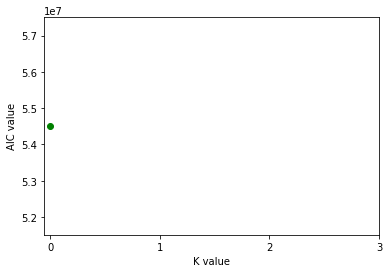

In [ ]:
import matplotlib.pyplot as plt

plt.plot(AIC_score, marker='o', color="g")
plt.xticks(np.arange(0, 3.2, 1))
plt.ylabel("AIC value")
plt.xlabel("K value")
# plt.savefig("/big/work/metadevol/benchmark_dataset1/AIC_cc7.png", format='png', dpi=600, bbox_inches = "tight")

Text(0.5, 0, ' iteration')

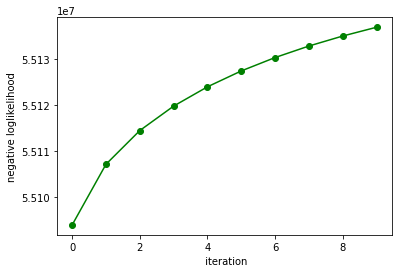

In [ ]:
import matplotlib.pyplot as plt
# LL = [3196371.6856573387, 3241404.4103596546, 3241404.410359654, 3241404.410359654, 3241404.4103596546, 3241404.4103596546, 3241404.4103596546, 3241404.4103596546, 3241404.4103596546, 3241404.4103596546, 3241404.4103596546]
plt.plot(LL, marker='o', color="g")
# plt.xticks(np.arange(0, 3.2, 1))
plt.ylabel("negative loglikelihood")
plt.xlabel(" iteration")

In [ ]:
Z_assign = Z_full
Rc_c  = np.sum(Z_assign, axis=0)
pb_c  = Z_assign / Rc_c
cov_b = np.sum(Z_assign, axis=1) / np.sum((np.array(lc) * Z_assign) / Rc_c, axis=1)
pb_min = 0.8 * (cov_b.reshape(len(cov_b),1) * np.sum(np.square(pb_c), axis=0) \
                / np.sum(cov_b.reshape(len(cov_b),1) * pb_c, axis=0))
pb_min[pb_min > 0.5] = 0.5
contig_assign0 = np.argmax(pb_c/pb_min, axis=0)
contig_assign0 = np.argmax(Z_assign, axis=0)
print(len(set(contig_assign0)), "number of bins")
print(len(set(tf.argmax(Z_assign, axis=0).numpy())), "just max")

contigs_assigned = []
for f in range(np.shape(Z_assign)[1]):
    contigs_assigned.append(Z_assign[contig_assign0[f],f])

bins0 = np.c_[np.array(contig_names),contig_assign0]

np.shape(bins0)

np.savetxt(tmp_dir + "contigbins_onlyZassign" , bins0, delimiter = " ", fmt=['%d','%d'])

24 number of bins
24 just max


In [ ]:
Z_assign[:,38109]

array([0.02625989, 0.06664234, 0.07372199, 0.04344115, 0.08419587,
       0.06165101, 0.06357543, 0.04233294, 0.05510622, 0.03009292,
       0.0731706 , 0.06334812, 0.05837392, 0.0644841 , 0.0554855 ,
       0.02913992, 0.04295817, 0.02792942, 0.03763562, 0.03511042,
       0.02874942, 0.01365748, 0.01935618, 0.01382941])

In [ ]:
    
    # """ Assignment """
Rc_c  = np.sum(Z, axis=0)
pb_c  = Z / Rc_c
cov_b = np.sum(Z, axis=1) / np.sum((np.array(lc) * Z) / Rc_c, axis=1)
pb_min = 0.8 * (cov_b.reshape(len(cov_b),1) * np.sum(np.square(pb_c), axis=0) \
                / np.sum(cov_b.reshape(len(cov_b),1) * pb_c, axis=0))
pb_min[pb_min > 0.5] = 0.5
contig_assign0 = tf.argmax(pb_c/pb_min, axis=0).numpy()

print(len(set(contig_assign0)), "number of bins")
    # print(len(set(tf.argmax(pb_c, axis=0).numpy())), "just max")

23 number of bins
